GRU
========================

Wszytywanie bibliotek. Parametr mode reguluje czy będziemy uczyć na nowo sieć czy wczytwywać wyuczone modele. Żeby wyuczyć model mode=1, w innym wypadku wczytywanie modelu.

In [22]:
from keras.datasets import imdb
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import MaxPooling1D, Conv1D, Dense, Flatten, Dropout, Embedding
from keras.models import load_model
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import tensorflow as tf
import shap
import time
mode=1

Analiza danych
-------------------------------------------

In [23]:
# edges = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")
# features = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_features.csv",header=None)
# classes = pd.read_csv("elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
# features.rename(columns = {0:'txId1'}, inplace = True)
# features = pd.merge(features, edges.groupby('txId1').count(), on="txId1", how="left")
# features.head()

In [24]:
edges = pd.read_csv("elliptic_bitcoin_dataset/augmented/elliptic_txs_edgelist.csv")
features = pd.read_csv("elliptic_bitcoin_dataset/augmented/elliptic_txs_features.csv",header=None)
classes = pd.read_csv("elliptic_bitcoin_dataset/augmented/elliptic_txs_classes.csv")
features.rename(columns = {0:'txId1'}, inplace = True)
edges.rename(columns = {'txId':'txId1'}, inplace = True)
features = pd.merge(features, edges.groupby('txId1').count(), on="txId1", how="left")
features.rename(columns = {'class':'txId2'}, inplace = True)
features.head()

txId1  1         2         3         4         5         6         7   
0  230425980  1 -0.056189 -0.175567 -1.185821 -0.186390 -0.046514 -0.167505  \
1    5530458  1 -0.056193 -0.175567 -1.185821 -0.186390 -0.046514 -0.167505   
2  232022460  1 -0.056378 -0.175567 -1.185821 -0.186390 -0.046514 -0.167505   
3  232438397  1  0.043005  0.743641 -0.644127  2.874647 -0.068726  2.304311   
4  230460314  1  0.294595 -0.131268 -1.185821  0.125213  0.375512  0.188604   

          8         9  ...       158       159       160       161       162   
0 -0.101009 -0.133295  ... -0.582752  1.442895  1.440189  0.003514 -0.092606  \
1 -0.101009 -0.133311  ...  0.702410 -1.033609 -1.032884  0.003514 -0.092606   
2 -0.101009 -0.133972  ...  0.467009 -1.033609 -1.032884 -0.106566 -0.113936   
3  3.142835 -0.134902  ... -0.595477  0.204643  0.203652  0.994235  0.099367   
4 -0.101009 -0.134776  ... -0.380435  0.484856  0.546219  0.003514  0.312670   

        163       164       165       166  txId2  
0 -0.135784 -0.101068 -0.102834 -0.102128    1.0  
1 -0.135784 -0.101068 -0.102834 -0.102128    1.0  
2 -0.135784 -0.186659 -0.102834 -0.102128    2.0  
3 -0.135784  0.669253 -0.102834 -0.102128    1.0  
4  0.369103  1.281230  0.201809  0.202687    8.0  

[5 rows x 168 columns]

In [25]:
y = classes[classes['class'] != 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
y['class']=y['class'].apply(lambda x: x=='1')
y = y.iloc[:, 1]
x_train, x_test, y_train, y_test= train_test_split(x,y)
y_train.head()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


216101    False
157650    False
164199    False
38437     False
130707    False
Name: class, dtype: bool

In [26]:
x_train['txId2']=x_train['txId2'].apply(lambda x: np.log(1+x))
x_train.head()

2         3         4         5         6         7         8   
216101 -0.056624 -0.175567 -1.185821 -0.168061 -0.046514 -0.167505 -0.021890  \
157650 -0.046937  0.181790  1.522650 -0.186390  0.286664 -0.167505 -0.101009   
164199 -0.020250 -0.089689  0.980956 -0.186390 -0.046514 -0.167505 -0.101009   
38437  -0.056364 -0.175567 -1.185821 -0.168061 -0.046514 -0.146557 -0.101009   
130707 -0.031149  0.607919  0.980956  0.381826 -0.046514  0.481871 -0.101009   

               9        10        11  ...       158       159       160   
216101 -0.134888 -0.089381 -0.024430  ... -0.589114 -1.033609 -1.032884  \
157650 -0.100140 -0.070132 -0.024475  ...  0.905251  0.631506  0.672110   
164199 -0.004587 -0.017173 -0.024475  ... -0.595477  0.204643  0.203652   
38437  -0.134745 -0.088944 -0.022872  ...  0.511544 -1.033609 -1.032884   
130707 -0.134233 -0.081974 -0.013625  ... -0.582752  1.442895  1.440189   

             161       162       163       164       165       166     txId2  
216101  0.003514 -0.092606 -0.135784 -0.101068 -0.102834 -0.102128  1.098612  
157650 -0.106566 -0.007284 -0.049824 -0.116172  0.578467  0.342526  1.791759  
164199  0.003514 -0.071275 -0.084494 -0.058272  1.569841  1.571490  0.000000  
38437   0.003514 -0.092606 -0.135784 -0.101068 -0.102834 -0.102128  0.693147  
130707  0.003514 -0.092606 -0.135784 -0.101068 -0.102834 -0.102128  1.098612  

[5 rows x 166 columns]

(array([7.1316e+04, 1.2100e+02, 9.0000e+00, 4.0000e+00, 4.0000e+01,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 3.0000e+00, 2.0000e+00]),
 array([  0. ,  47.2,  94.4, 141.6, 188.8, 236. , 283.2, 330.4, 377.6,
        424.8, 472. ]),
 <BarContainer object of 10 artists>)

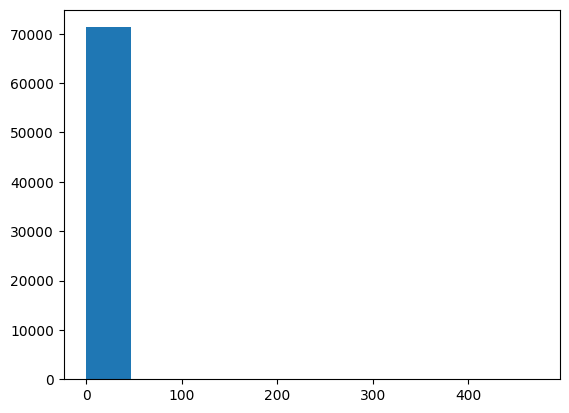

In [27]:
plt.hist(x['txId2'])

(array([8.8290e+03, 4.0203e+04, 2.5820e+03, 9.3600e+02, 6.5700e+02,
        2.6700e+02, 8.1000e+01, 3.0000e+01, 3.2000e+01, 5.0000e+00]),
 array([0.        , 0.61590954, 1.23181908, 1.84772862, 2.46363816,
        3.07954769, 3.69545723, 4.31136677, 4.92727631, 5.54318585,
        6.15909539]),
 <BarContainer object of 10 artists>)

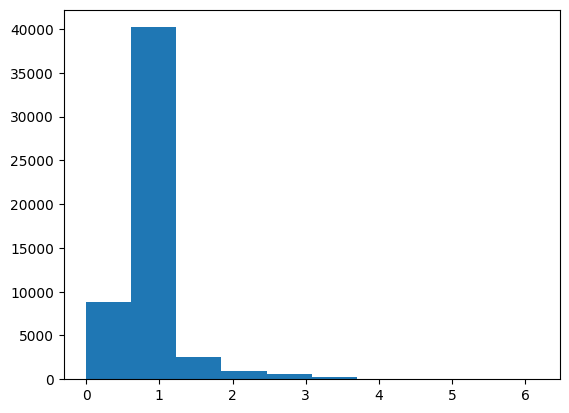

In [28]:
plt.hist(x_train['txId2'])

In [29]:
y = classes[classes['class'] == 'unknown']
x = features[features.iloc[:, 0].isin(y['txId'])]
x = x.iloc[:, 2:]
x.fillna(0, inplace=True)
x['txId2']=x['txId2'].apply(lambda x: np.log(1+x))

Uczenie modeli
----------------------

Ucznie modelu z funkcją straty mse

In [30]:
def createModel(lossFunction, num):
    if mode==1:
        model = Sequential()
        model.add(Conv1D(64, 3, activation='relu', input_shape=(166, 1)))
        model.add(MaxPooling1D(pool_size=4))
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.5))
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss=lossFunction, optimizer='adam', metrics=['mse', 'accuracy', tf.metrics.SensitivityAtSpecificity(0.5), tf.keras.metrics.AUC(num_thresholds=3), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])
        history = model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))
        model.save(lossFunction+"_cnn0"+str(num))
        return model, history
    else:
        model = load_model(lossFunction+"_"+str(num))
        return model, []

In [31]:
def evalModel(model):
    res=np.round(model.predict(x))
    unique, counts = np.unique(res, return_counts=True)
    if(len(counts)==1):
        counts = np.append(counts, 0)
    dict(zip(unique, counts))
    classes_illicit = classes[classes['class'] == '1']
    classes_licit = classes[classes['class'] == '2']
    res = np.round(model.predict(x_test))
    confusion_matrix = metrics.confusion_matrix(y_test, res)
    return res, confusion_matrix, classes_illicit['txId'].count()/classes_licit['txId'].count(), counts[1]/counts[0]

In [32]:
def displayConfunsion(axs,x,y,confusion_matrix):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot(ax=axs[x,y], cmap=plt.cm.Blues, xticks_rotation='vertical')
    
def displayResult(exampleCount, predictedCount):
    print("Marked example proportion: "+str(exampleCount)+" - Predicted proportion: "+str(predictedCount))

In [33]:
def createTeamOfModels(lossFunction, shapEnabled):
    meanPredicted=[]
    for i in range(6):
        model, history=createModel(lossFunction, i)
        res, matrix, examplesCount, predictedCount = evalModel(model)
        shap_values=""
        if shapEnabled==1 and i==5:
            start = time.time()
            explainer = shap.GradientExplainer(model, np.array(x_train).reshape(x_train.shape[0],x_train.shape[1],1))
            shap_values = explainer(np.array(x_train).reshape(x_train.shape[0],x_train.shape[1],1))
            end = time.time()
            print("SHAP execution time:")
            print(end - start)
        meanPredicted.append((res, matrix, examplesCount, predictedCount, history, shap_values))
    return meanPredicted

In [34]:
def displaySummarization(meanPredicted, shapEnabled, plotCounter):
    fig, axs = plt.subplots(3, 2)
    fig2, axs2 = plt.subplots(3, 2)
    fig3, mse = plt.subplots(3, 2)
    fig4, accuracy = plt.subplots(3, 2)
    fig5, sensivity = plt.subplots(3, 2)
    fig6, auc = plt.subplots(3, 2)
    fig7, recall = plt.subplots(3, 2)
    fig8, prec = plt.subplots(3, 2)
    meanTotal=[0,0]
    for i in range(3):
        for v in range(2):
            ind=i+v*3
            displayConfunsion(axs,i,v,meanPredicted[ind][1])
            displayResult(meanPredicted[ind][2],meanPredicted[i+v*3][3])            
            fpr, tpr, thresholds = roc_curve(y_test, meanPredicted[i+v*3][0])
            auc1 = roc_auc_score(y_test, meanPredicted[ind][0])
            axs2[i,v].plot(fpr, tpr, label='roc'+str(i+v*3))
            metricsList = [elem for elem in meanPredicted[0][4].history.values()]
            if mode==1:
                mse[i,v].plot(metricsList[1], label='Training MSE')
                mse[i,v].plot(metricsList[8], label='Validation MSE')
                if ind==0:
                    mse[i,v].legend()
                
                accuracy[i,v].plot(metricsList[2], label='Training Accuracy')
                accuracy[i,v].plot(metricsList[9], label='Validation Accuracy')
                if ind==0:
                    accuracy[i,v].legend()
                
                sensivity[i,v].plot(metricsList[3], label='Training Sensivity')
                sensivity[i,v].plot(metricsList[10], label='Validation Sensivity')
                if ind==0:
                    sensivity[i,v].legend()
                
                auc[i,v].plot(metricsList[4], label='Training Auc')
                auc[i,v].plot(metricsList[11], label='Validation Auc')
                if ind==0:
                    auc[i,v].legend()
                
                recall[i,v].plot(metricsList[5], label='Training Recall')
                recall[i,v].plot(metricsList[12], label='Validation Recall')
                if ind==0:
                    recall[i,v].legend()
                
                prec[i,v].plot(metricsList[6], label='Training Precision')
                prec[i,v].plot(metricsList[13], label='Validation Precision')
                if ind==0:
                    prec[i,v].legend()
                
            meanTotal[0]=meanTotal[0]+meanPredicted[i+v*3][2]
            meanTotal[1]=meanTotal[1]+meanPredicted[i+v*3][3]
            plotCounter=plotCounter+1

In [35]:
def displayShap(meanPredicted, shapEnabled):
    for i in range(3):
        for v in range(2):
            ind=i+v*3
            if shapEnabled==1 and ind==5:
                dp=meanPredicted[i+v*3][5].values[0]
                dp=dp.reshape(dp.shape[0], dp.shape[1])
                shap.summary_plot(dp, x_train,plot_type='bar')
                fig = shap.summary_plot(dp, x_train,feature_names=x_train.columns.tolist(), show=False)
                _, h = plt.gcf().get_size_inches()
                plt.gcf().set_size_inches(h*50, h)
                plt.show()

Epoch 1/5
1676/1676 [==============================] - 10s 5ms/step - loss: 0.1231 - mse: 0.0317 - accuracy: 0.9590 - sensitivity_at_specificity: 0.9648 - auc: 0.7019 - recall: 0.4069 - precision: 0.8972 - val_loss: 0.0952 - val_mse: 0.0253 - val_accuracy: 0.9690 - val_sensitivity_at_specificity: 0.9694 - val_auc: 0.7782 - val_recall: 0.5603 - val_precision: 0.9055
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0941 - mse: 0.0236 - accuracy: 0.9735 - sensitivity_at_specificity: 0.9694 - auc: 0.8355 - recall: 0.6773 - precision: 0.8813 - val_loss: 0.0814 - val_mse: 0.0201 - val_accuracy: 0.9748 - val_sensitivity_at_specificity: 0.9622 - val_auc: 0.8459 - val_recall: 0.6987 - val_precision: 0.8711
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0858 - mse: 0.0207 - accuracy: 0.9767 - sensitivity_at_specificity: 0.9700 - auc: 0.8612 - recall: 0.7288 - precision: 0.8863 - val_loss: 0.0726 - val_mse: 0.0184 - val_accuracy: 0.9783 - 

INFO:tensorflow:Assets written to: binary_crossentropy_cnn00\assets


INFO:tensorflow:Assets written to: binary_crossentropy_cnn00\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1191 - mse: 0.0305 - accuracy: 0.9576 - sensitivity_at_specificity_1: 0.9624 - auc_1: 0.6991 - recall_1: 0.4026 - precision_1: 0.8616 - val_loss: 0.0996 - val_mse: 0.0242 - val_accuracy: 0.9698 - val_sensitivity_at_specificity_1: 0.9335 - val_auc_1: 0.7899 - val_recall_1: 0.5845 - val_precision_1: 0.8929
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0925 - mse: 0.0227 - accuracy: 0.9725 - sensitivity_at_specificity_1: 0.9665 - auc_1: 0.8237 - recall_1: 0.6531 - precision_1: 0.8879 - val_loss: 0.0768 - val_mse: 0.0197 - val_accuracy: 0.9767 - val_sensitivity_at_specificity_1: 0.9847 - val_auc_1: 0.8423 - val_recall_1: 0.6888 - val_precision_1: 0.9163
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0850 - mse: 0.0208 - accuracy: 0.9763 - sensitivity_at_specificity_1: 0.9680 - auc_1: 0.8461 - recall_

INFO:tensorflow:Assets written to: binary_crossentropy_cnn01\assets


INFO:tensorflow:Assets written to: binary_crossentropy_cnn01\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1193 - mse: 0.0305 - accuracy: 0.9588 - sensitivity_at_specificity_2: 0.9627 - auc_2: 0.7146 - recall_2: 0.4346 - precision_2: 0.8482 - val_loss: 0.0901 - val_mse: 0.0237 - val_accuracy: 0.9715 - val_sensitivity_at_specificity_2: 0.9784 - val_auc_2: 0.8014 - val_recall_2: 0.6070 - val_precision_2: 0.9036
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0947 - mse: 0.0238 - accuracy: 0.9731 - sensitivity_at_specificity_2: 0.9680 - auc_2: 0.8293 - recall_2: 0.6644 - precision_2: 0.8879 - val_loss: 0.0858 - val_mse: 0.0217 - val_accuracy: 0.9745 - val_sensitivity_at_specificity_2: 0.9658 - val_auc_2: 0.8219 - val_recall_2: 0.6475 - val_precision_2: 0.9195
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0881 - mse: 0.0215 - accuracy: 0.9773 - sensitivity_at_specificity_2: 0.9677 - auc_2: 0.8611 - recall_

INFO:tensorflow:Assets written to: binary_crossentropy_cnn02\assets


INFO:tensorflow:Assets written to: binary_crossentropy_cnn02\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1136 - mse: 0.0284 - accuracy: 0.9646 - sensitivity_at_specificity_3: 0.9627 - auc_3: 0.7657 - recall_3: 0.5377 - precision_3: 0.8550 - val_loss: 0.0857 - val_mse: 0.0218 - val_accuracy: 0.9720 - val_sensitivity_at_specificity_3: 0.9712 - val_auc_3: 0.8259 - val_recall_3: 0.6592 - val_precision_3: 0.8573
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0908 - mse: 0.0220 - accuracy: 0.9728 - sensitivity_at_specificity_3: 0.9691 - auc_3: 0.8285 - recall_3: 0.6630 - precision_3: 0.8832 - val_loss: 0.0863 - val_mse: 0.0216 - val_accuracy: 0.9713 - val_sensitivity_at_specificity_3: 0.9559 - val_auc_3: 0.7886 - val_recall_3: 0.5800 - val_precision_3: 0.9334
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0847 - mse: 0.0207 - accuracy: 0.9755 - sensitivity_at_specificity_3: 0.9738 - auc_3: 0.8447 - recall_

INFO:tensorflow:Assets written to: binary_crossentropy_cnn03\assets


INFO:tensorflow:Assets written to: binary_crossentropy_cnn03\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1132 - mse: 0.0287 - accuracy: 0.9628 - sensitivity_at_specificity_4: 0.9653 - auc_4: 0.7500 - recall_4: 0.5060 - precision_4: 0.8536 - val_loss: 0.0901 - val_mse: 0.0227 - val_accuracy: 0.9730 - val_sensitivity_at_specificity_4: 0.9613 - val_auc_4: 0.8114 - val_recall_4: 0.6268 - val_precision_4: 0.9123
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0891 - mse: 0.0217 - accuracy: 0.9738 - sensitivity_at_specificity_4: 0.9691 - auc_4: 0.8359 - recall_4: 0.6778 - precision_4: 0.8855 - val_loss: 0.0782 - val_mse: 0.0190 - val_accuracy: 0.9770 - val_sensitivity_at_specificity_4: 0.9685 - val_auc_4: 0.8601 - val_recall_4: 0.7266 - val_precision_4: 0.8831
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0823 - mse: 0.0200 - accuracy: 0.9759 - sensitivity_at_specificity_4: 0.9726 - auc_4: 0.8493 - recall_

INFO:tensorflow:Assets written to: binary_crossentropy_cnn04\assets


INFO:tensorflow:Assets written to: binary_crossentropy_cnn04\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1164 - mse: 0.0294 - accuracy: 0.9620 - sensitivity_at_specificity_5: 0.9627 - auc_5: 0.7444 - recall_5: 0.4949 - precision_5: 0.8487 - val_loss: 0.0885 - val_mse: 0.0224 - val_accuracy: 0.9719 - val_sensitivity_at_specificity_5: 0.9748 - val_auc_5: 0.8364 - val_recall_5: 0.6817 - val_precision_5: 0.8357
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0896 - mse: 0.0221 - accuracy: 0.9732 - sensitivity_at_specificity_5: 0.9703 - auc_5: 0.8306 - recall_5: 0.6671 - precision_5: 0.8859 - val_loss: 0.0833 - val_mse: 0.0205 - val_accuracy: 0.9750 - val_sensitivity_at_specificity_5: 0.9559 - val_auc_5: 0.8280 - val_recall_5: 0.6601 - val_precision_5: 0.9141
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0826 - mse: 0.0202 - accuracy: 0.9767 - sensitivity_at_specificity_5: 0.9715 - auc_5: 0.8520 - recall_

INFO:tensorflow:Assets written to: binary_crossentropy_cnn05\assets


INFO:tensorflow:Assets written to: binary_crossentropy_cnn05\assets


559/559 [==============================] - 1s 2ms/step


`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


SHAP execution time:
1029.0502879619598
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05401865510652723
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.06042942407565305
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05246718877417568
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04475659053650887
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05840029708179033
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.041347603026474035


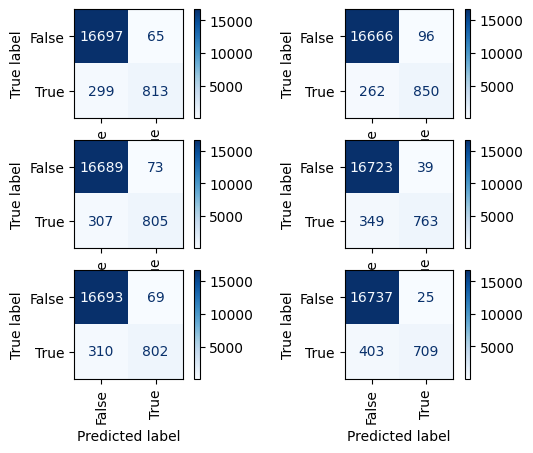

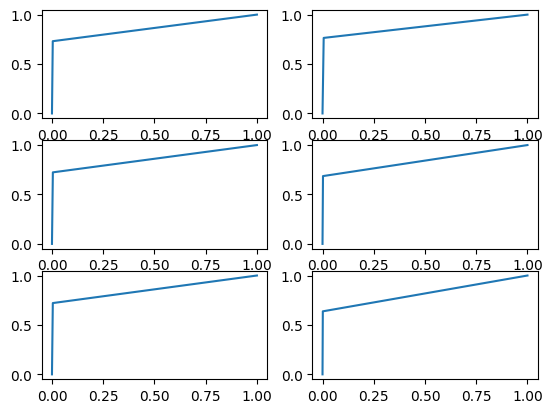

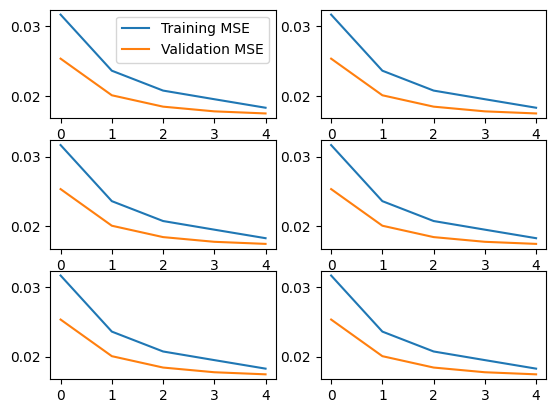

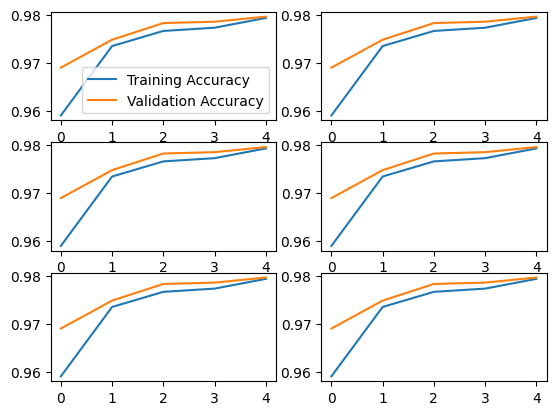

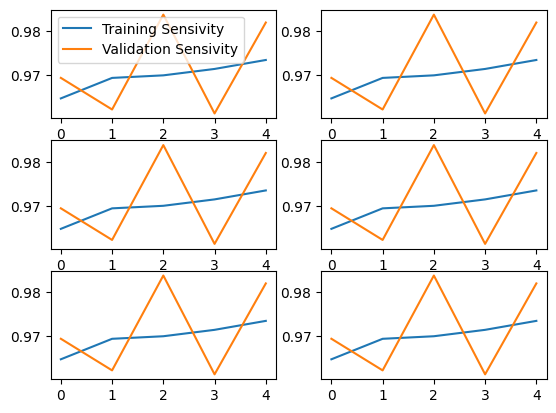

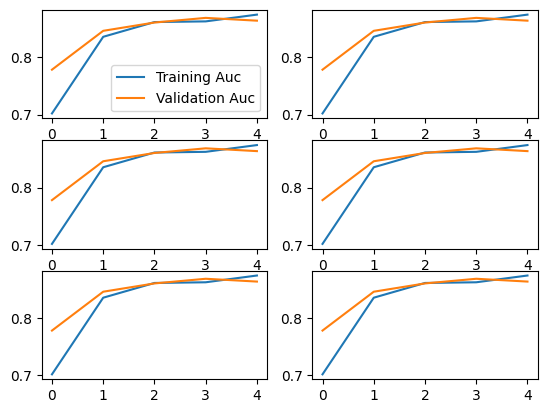

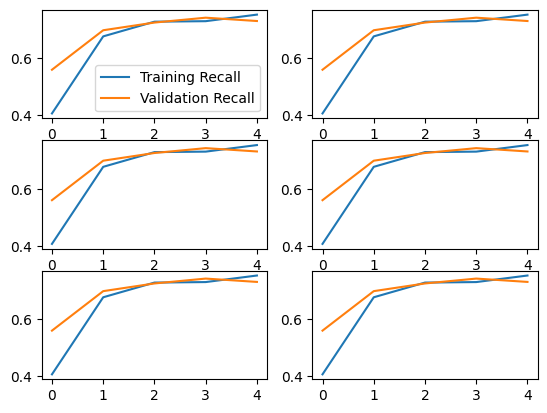

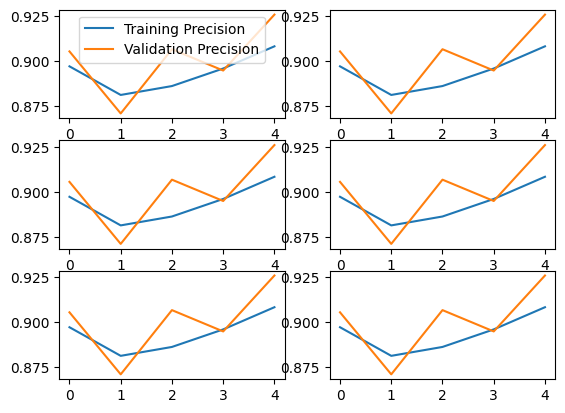

In [15]:
meanPredicted=createTeamOfModels('binary_crossentropy', 1)
displaySummarization(meanPredicted, 1, 0)

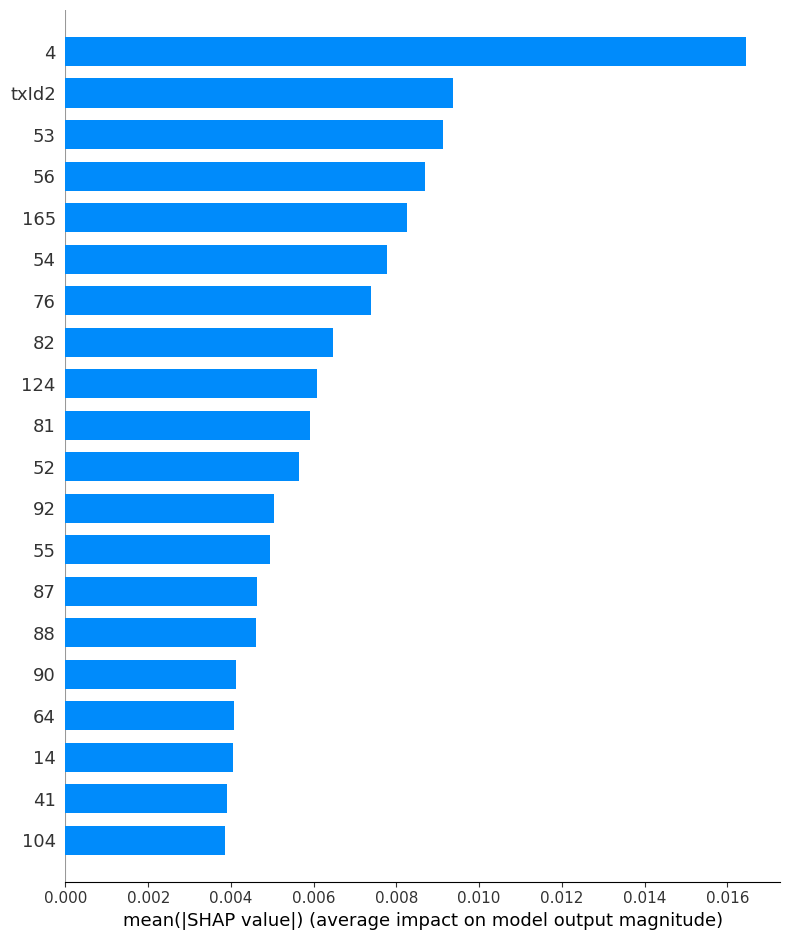

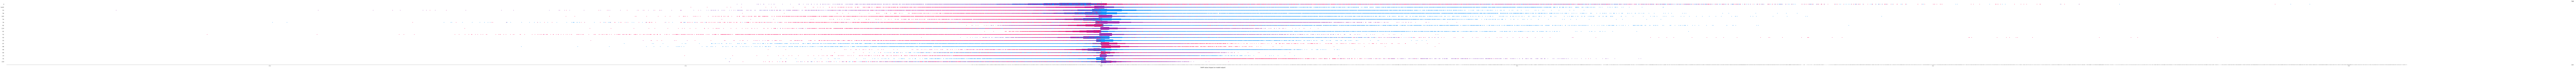

In [16]:
displayShap(meanPredicted, 1)

Funkcja binarnej krosentropii

Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.0315 - mse: 0.0315 - accuracy: 0.9640 - sensitivity_at_specificity_6: 0.7859 - auc_6: 0.7575 - recall_6: 0.5205 - precision_6: 0.8637 - val_loss: 0.0274 - val_mse: 0.0274 - val_accuracy: 0.9712 - val_sensitivity_at_specificity_6: 0.7536 - val_auc_6: 0.7974 - val_recall_6: 0.5989 - val_precision_6: 0.9074
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0259 - mse: 0.0259 - accuracy: 0.9725 - sensitivity_at_specificity_6: 0.7693 - auc_6: 0.8265 - recall_6: 0.6592 - precision_6: 0.8805 - val_loss: 0.0240 - val_mse: 0.0240 - val_accuracy: 0.9734 - val_sensitivity_at_specificity_6: 0.7599 - val_auc_6: 0.8359 - val_recall_6: 0.6790 - val_precision_6: 0.8638
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0240 - mse: 0.0240 - accuracy: 0.9741 - sensitivity_at_specificity_6: 0.7643 - auc_6: 0.8379 - recall_6: 0.6816 - precision_6: 0.8877 - val_loss: 0.0236 - va

INFO:tensorflow:Assets written to: mse_cnn00\assets


INFO:tensorflow:Assets written to: mse_cnn00\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.0306 - mse: 0.0306 - accuracy: 0.9642 - sensitivity_at_specificity_7: 0.7812 - auc_7: 0.7647 - recall_7: 0.5360 - precision_7: 0.8499 - val_loss: 0.0286 - val_mse: 0.0286 - val_accuracy: 0.9700 - val_sensitivity_at_specificity_7: 0.7383 - val_auc_7: 0.7825 - val_recall_7: 0.5683 - val_precision_7: 0.9173
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0252 - mse: 0.0252 - accuracy: 0.9729 - sensitivity_at_specificity_7: 0.7632 - auc_7: 0.8273 - recall_7: 0.6604 - precision_7: 0.8883 - val_loss: 0.0244 - val_mse: 0.0244 - val_accuracy: 0.9726 - val_sensitivity_at_specificity_7: 0.7545 - val_auc_7: 0.8162 - val_recall_7: 0.6376 - val_precision_7: 0.8918
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0237 - mse: 0.0237 - accuracy: 0.9739 - sensitivity_at_specificity_7: 0.7673 - auc_7: 0.8350 - recall_

INFO:tensorflow:Assets written to: mse_cnn01\assets


INFO:tensorflow:Assets written to: mse_cnn01\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.0333 - mse: 0.0333 - accuracy: 0.9638 - sensitivity_at_specificity_8: 0.7888 - auc_8: 0.7546 - recall_8: 0.5147 - precision_8: 0.8662 - val_loss: 0.0280 - val_mse: 0.0280 - val_accuracy: 0.9700 - val_sensitivity_at_specificity_8: 0.7491 - val_auc_8: 0.7989 - val_recall_8: 0.6034 - val_precision_8: 0.8760
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0260 - mse: 0.0260 - accuracy: 0.9718 - sensitivity_at_specificity_8: 0.7678 - auc_8: 0.8286 - recall_8: 0.6644 - precision_8: 0.8637 - val_loss: 0.0251 - val_mse: 0.0251 - val_accuracy: 0.9726 - val_sensitivity_at_specificity_8: 0.7518 - val_auc_8: 0.8083 - val_recall_8: 0.6205 - val_precision_8: 0.9115
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0238 - mse: 0.0238 - accuracy: 0.9747 - sensitivity_at_specificity_8: 0.7658 - auc_8: 0.8413 - recall_

INFO:tensorflow:Assets written to: mse_cnn02\assets


INFO:tensorflow:Assets written to: mse_cnn02\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.0318 - mse: 0.0318 - accuracy: 0.9637 - sensitivity_at_specificity_9: 0.7987 - auc_9: 0.7600 - recall_9: 0.5264 - precision_9: 0.8500 - val_loss: 0.0272 - val_mse: 0.0272 - val_accuracy: 0.9713 - val_sensitivity_at_specificity_9: 0.7545 - val_auc_9: 0.8109 - val_recall_9: 0.6277 - val_precision_9: 0.8758
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0259 - mse: 0.0259 - accuracy: 0.9727 - sensitivity_at_specificity_9: 0.7708 - auc_9: 0.8253 - recall_9: 0.6563 - precision_9: 0.8877 - val_loss: 0.0246 - val_mse: 0.0246 - val_accuracy: 0.9732 - val_sensitivity_at_specificity_9: 0.7554 - val_auc_9: 0.8148 - val_recall_9: 0.6340 - val_precision_9: 0.9073
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0238 - mse: 0.0238 - accuracy: 0.9744 - sensitivity_at_specificity_9: 0.7667 - auc_9: 0.8394 - recall_

INFO:tensorflow:Assets written to: mse_cnn03\assets


INFO:tensorflow:Assets written to: mse_cnn03\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.0304 - mse: 0.0304 - accuracy: 0.9648 - sensitivity_at_specificity_10: 0.7748 - auc_10: 0.7755 - recall_10: 0.5584 - precision_10: 0.8368 - val_loss: 0.0268 - val_mse: 0.0268 - val_accuracy: 0.9711 - val_sensitivity_at_specificity_10: 0.7509 - val_auc_10: 0.7911 - val_recall_10: 0.5854 - val_precision_10: 0.9221
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0247 - mse: 0.0247 - accuracy: 0.9724 - sensitivity_at_specificity_10: 0.7719 - auc_10: 0.8271 - recall_10: 0.6604 - precision_10: 0.8790 - val_loss: 0.0242 - val_mse: 0.0242 - val_accuracy: 0.9736 - val_sensitivity_at_specificity_10: 0.7527 - val_auc_10: 0.8155 - val_recall_10: 0.6349 - val_precision_10: 0.9157
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0233 - mse: 0.0233 - accuracy: 0.9747 - sensitivity_at_specificity_10: 0.7661 - auc_10

INFO:tensorflow:Assets written to: mse_cnn04\assets


INFO:tensorflow:Assets written to: mse_cnn04\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.0330 - mse: 0.0330 - accuracy: 0.9649 - sensitivity_at_specificity_11: 0.7850 - auc_11: 0.7619 - recall_11: 0.5290 - precision_11: 0.8731 - val_loss: 0.0311 - val_mse: 0.0311 - val_accuracy: 0.9662 - val_sensitivity_at_specificity_11: 0.7509 - val_auc_11: 0.7528 - val_recall_11: 0.5090 - val_precision_11: 0.9071
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0268 - mse: 0.0268 - accuracy: 0.9720 - sensitivity_at_specificity_11: 0.7684 - auc_11: 0.8278 - recall_11: 0.6624 - precision_11: 0.8699 - val_loss: 0.0261 - val_mse: 0.0261 - val_accuracy: 0.9726 - val_sensitivity_at_specificity_11: 0.7482 - val_auc_11: 0.8103 - val_recall_11: 0.6250 - val_precision_11: 0.9049
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0244 - mse: 0.0244 - accuracy: 0.9736 - sensitivity_at_specificity_11: 0.7652 - auc_11

INFO:tensorflow:Assets written to: mse_cnn05\assets


INFO:tensorflow:Assets written to: mse_cnn05\assets


559/559 [==============================] - 1s 2ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.040872224842886926
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.042892935370917165
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04429403831963563
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.042278487441907715
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.046504156254780965
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04704879890605547


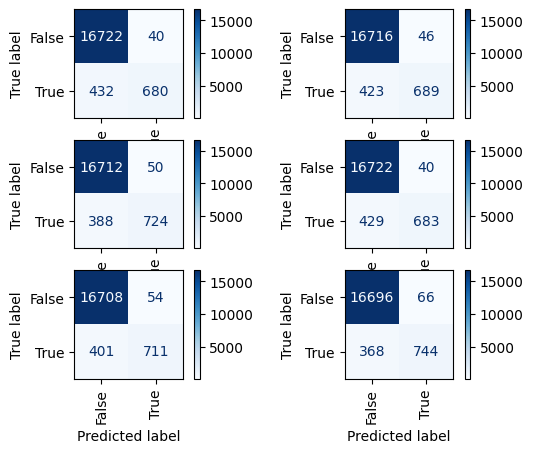

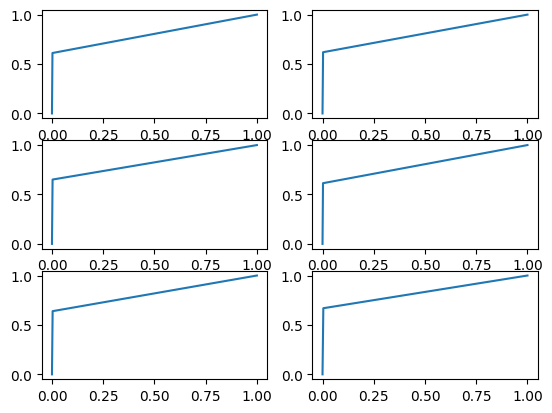

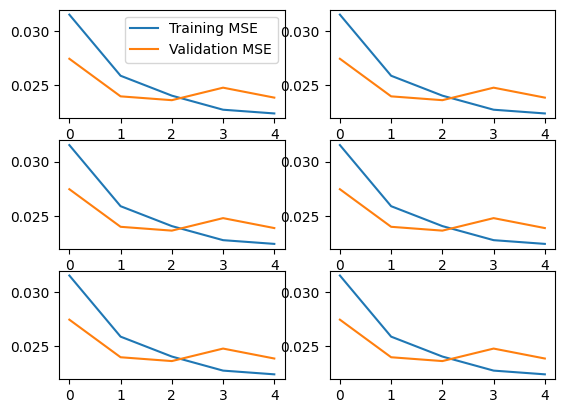

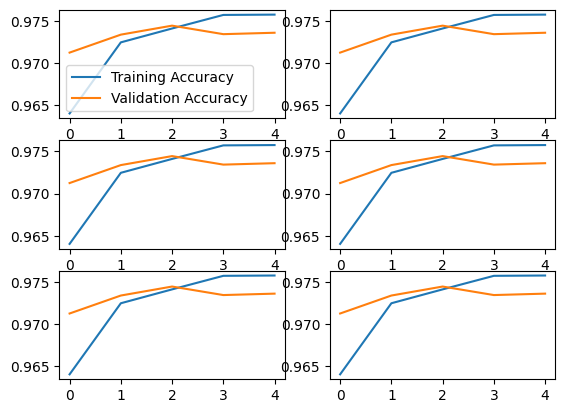

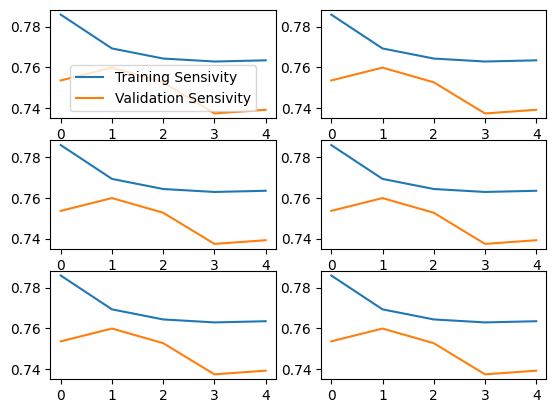

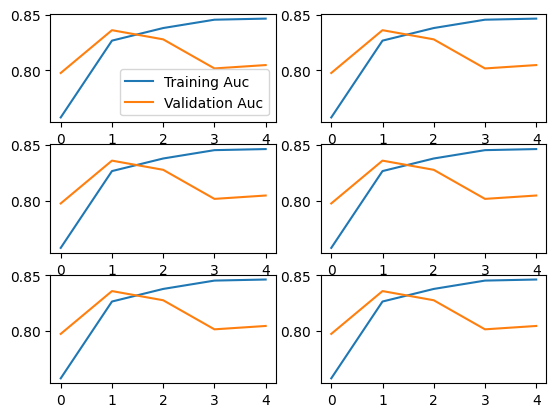

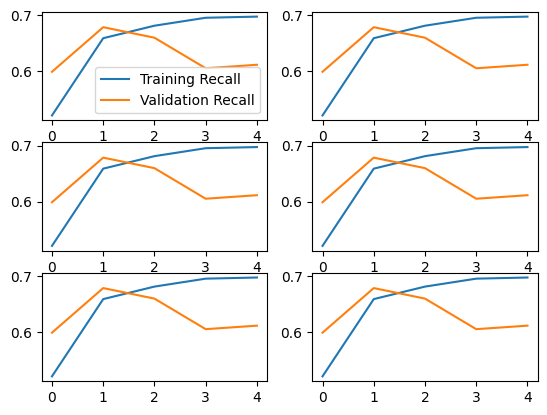

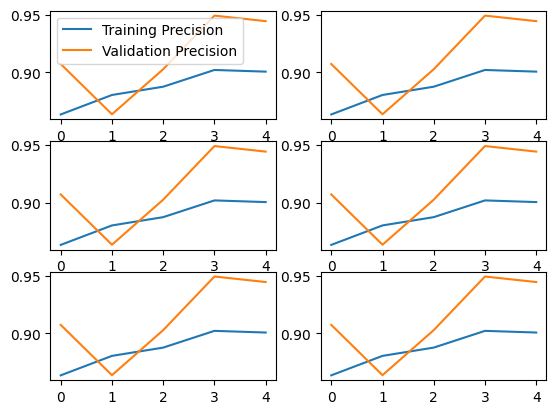

In [17]:
meanPredicted=createTeamOfModels('mse',0)
displaySummarization(meanPredicted,0,6)

Funkcja kullbacka-leiblera

Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 8.3518e-05 - mse: 0.9350 - accuracy: 0.0641 - sensitivity_at_specificity_12: 0.0000e+00 - auc_12: 0.4998 - recall_12: 0.9994 - precision_12: 0.0640 - val_loss: -1.5101e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_12: 0.0000e+00 - val_auc_12: 0.5000 - val_recall_12: 1.0000 - val_precision_12: 0.0622
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4728e-06 - mse: 0.9360 - accuracy: 0.0640 - sensitivity_at_specificity_12: 0.0000e+00 - auc_12: 0.5000 - recall_12: 1.0000 - precision_12: 0.0640 - val_loss: -1.5115e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_12: 0.0000e+00 - val_auc_12: 0.5000 - val_recall_12: 1.0000 - val_precision_12: 0.0622
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4935e-06 - mse: 0.9360 - accuracy: 0.0640 - sensitivity_at_specificity_12: 0.0000e+00 - auc_12: 0.5000 - 

INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn00\assets


INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn00\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 1.2436e-04 - mse: 0.9348 - accuracy: 0.0642 - sensitivity_at_specificity_13: 0.0000e+00 - auc_13: 0.4998 - recall_13: 0.9994 - precision_13: 0.0640 - val_loss: -1.5066e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_13: 0.0000e+00 - val_auc_13: 0.5000 - val_recall_13: 1.0000 - val_precision_13: 0.0622
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4503e-06 - mse: 0.9360 - accuracy: 0.0640 - sensitivity_at_specificity_13: 0.0000e+00 - auc_13: 0.5000 - recall_13: 1.0000 - precision_13: 0.0640 - val_loss: -1.5114e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_13: 0.0000e+00 - val_auc_13: 0.5000 - val_recall_13: 1.0000 - val_precision_13: 0.0622
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4854e-06 - mse: 0.9360 - accuracy: 0.0640 - sensit

INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn01\assets


INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn01\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 6.2302e-05 - mse: 0.9351 - accuracy: 0.0642 - sensitivity_at_specificity_14: 0.0000e+00 - auc_14: 0.5001 - recall_14: 1.0000 - precision_14: 0.0640 - val_loss: -1.5101e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_14: 0.0000e+00 - val_auc_14: 0.5000 - val_recall_14: 1.0000 - val_precision_14: 0.0622
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4811e-06 - mse: 0.9360 - accuracy: 0.0640 - sensitivity_at_specificity_14: 0.0000e+00 - auc_14: 0.5000 - recall_14: 1.0000 - precision_14: 0.0640 - val_loss: -1.5115e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_14: 0.0000e+00 - val_auc_14: 0.5000 - val_recall_14: 1.0000 - val_precision_14: 0.0622
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4994e-06 - mse: 0.9360 - accuracy: 0.0640 - sensit

INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn02\assets


INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn02\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 6.2781e-05 - mse: 0.9351 - accuracy: 0.0641 - sensitivity_at_specificity_15: 0.0000e+00 - auc_15: 0.5000 - recall_15: 1.0000 - precision_15: 0.0640 - val_loss: -1.5100e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_15: 0.0000e+00 - val_auc_15: 0.5000 - val_recall_15: 1.0000 - val_precision_15: 0.0622
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4784e-06 - mse: 0.9360 - accuracy: 0.0640 - sensitivity_at_specificity_15: 0.0000e+00 - auc_15: 0.5000 - recall_15: 1.0000 - precision_15: 0.0640 - val_loss: -1.5115e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_15: 0.0000e+00 - val_auc_15: 0.5000 - val_recall_15: 1.0000 - val_precision_15: 0.0622
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.5015e-06 - mse: 0.9360 - accuracy: 0.0640 - sensit

INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn03\assets


INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn03\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 7.5962e-05 - mse: 0.9351 - accuracy: 0.0643 - sensitivity_at_specificity_16: 0.0000e+00 - auc_16: 0.5001 - recall_16: 1.0000 - precision_16: 0.0640 - val_loss: -1.5099e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_16: 0.0000e+00 - val_auc_16: 0.5000 - val_recall_16: 1.0000 - val_precision_16: 0.0622
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4562e-06 - mse: 0.9360 - accuracy: 0.0640 - sensitivity_at_specificity_16: 0.0000e+00 - auc_16: 0.5000 - recall_16: 1.0000 - precision_16: 0.0640 - val_loss: -1.5115e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_16: 0.0000e+00 - val_auc_16: 0.5000 - val_recall_16: 1.0000 - val_precision_16: 0.0622
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4864e-06 - mse: 0.9360 - accuracy: 0.0640 - sensit

INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn04\assets


INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn04\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 1.0589e-04 - mse: 0.9350 - accuracy: 0.0643 - sensitivity_at_specificity_17: 0.0000e+00 - auc_17: 0.4997 - recall_17: 0.9991 - precision_17: 0.0640 - val_loss: -1.5088e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_17: 0.0000e+00 - val_auc_17: 0.5000 - val_recall_17: 1.0000 - val_precision_17: 0.0622
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4781e-06 - mse: 0.9360 - accuracy: 0.0640 - sensitivity_at_specificity_17: 0.0000e+00 - auc_17: 0.5000 - recall_17: 1.0000 - precision_17: 0.0640 - val_loss: -1.5115e-06 - val_mse: 0.9378 - val_accuracy: 0.0622 - val_sensitivity_at_specificity_17: 0.0000e+00 - val_auc_17: 0.5000 - val_recall_17: 1.0000 - val_precision_17: 0.0622
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: -1.4952e-06 - mse: 0.9360 - accuracy: 0.0640 - sensit

INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn05\assets


INFO:tensorflow:Assets written to: kullback_leibler_divergence_cnn05\assets


559/559 [==============================] - 1s 2ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0


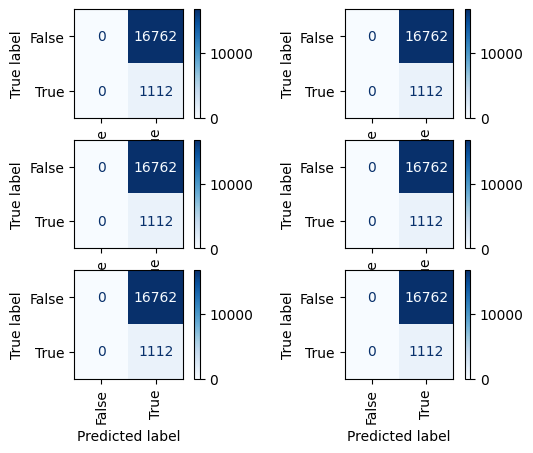

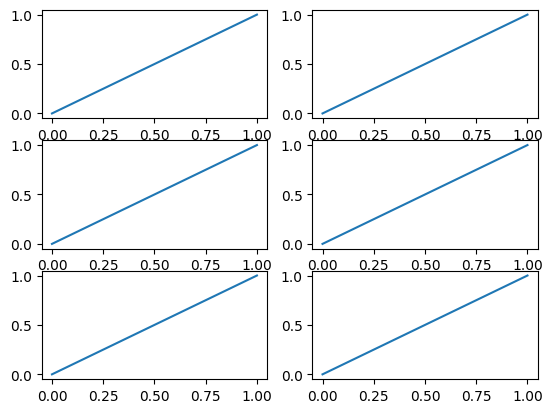

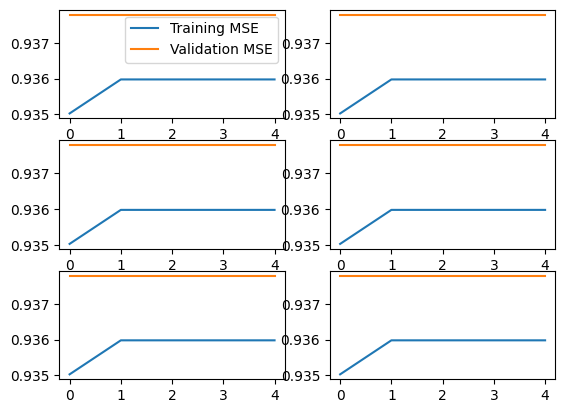

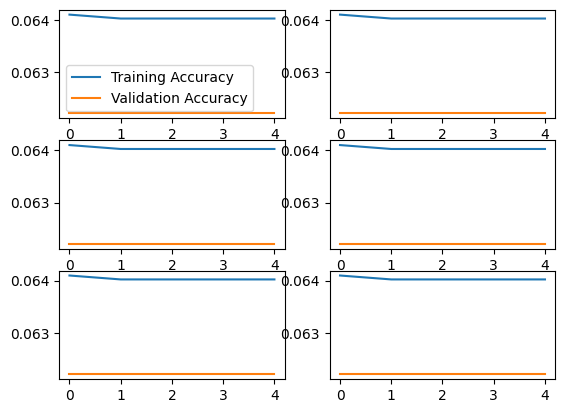

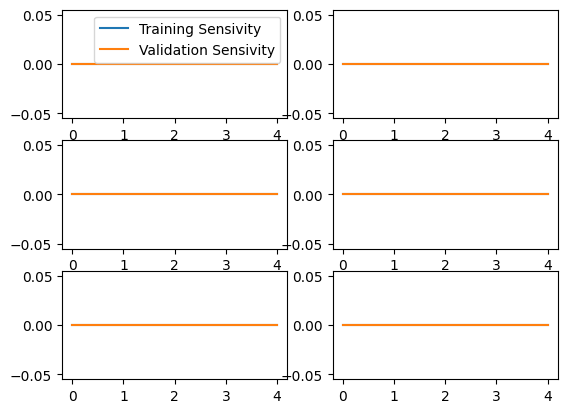

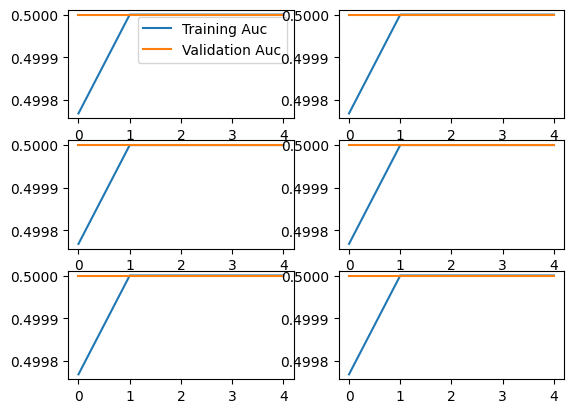

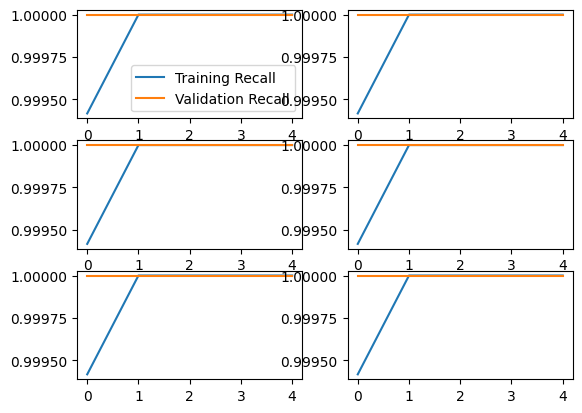

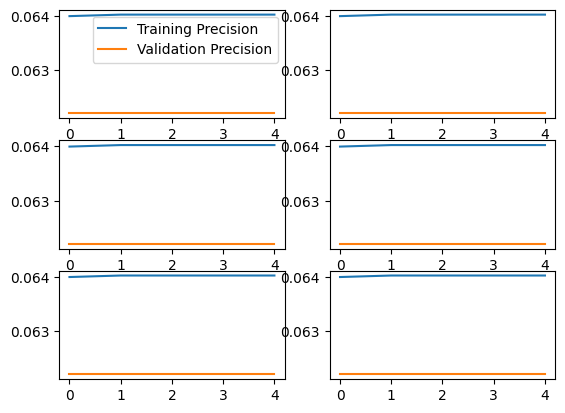

In [18]:
meanPredicted=createTeamOfModels('kullback_leibler_divergence',0)
displaySummarization(meanPredicted,0,12)

Funkcja sparse_categorical_crossentropy

Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1464 - mse: 0.0338 - accuracy: 0.9522 - sensitivity_at_specificity_31: 0.9648 - auc_31: 0.6402 - recall_31: 0.2825 - precision_31: 0.9065 - val_loss: 0.1362 - val_mse: 0.0303 - val_accuracy: 0.9566 - val_sensitivity_at_specificity_31: 0.9307 - val_auc_31: 0.6613 - val_recall_31: 0.3240 - val_precision_31: 0.9351
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1298 - mse: 0.0279 - accuracy: 0.9698 - sensitivity_at_specificity_31: 0.9715 - auc_31: 0.7923 - recall_31: 0.5888 - precision_31: 0.9071 - val_loss: 0.1317 - val_mse: 0.0294 - val_accuracy: 0.9594 - val_sensitivity_at_specificity_31: 0.9388 - val_auc_31: 0.6809 - val_recall_31: 0.3627 - val_precision_31: 0.9595
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1245 - mse: 0.0255 - accuracy: 0.9735 - sensitivity_at_specificity_31: 0.9755 - auc_31: 0.8267 - recall_31: 0.6584 - precision_31: 0.9008 - v

INFO:tensorflow:Assets written to: poisson_cnn00\assets


INFO:tensorflow:Assets written to: poisson_cnn00\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1427 - mse: 0.0305 - accuracy: 0.9573 - sensitivity_at_specificity_32: 0.9619 - auc_32: 0.7046 - recall_32: 0.4147 - precision_32: 0.8372 - val_loss: 0.1210 - val_mse: 0.0234 - val_accuracy: 0.9691 - val_sensitivity_at_specificity_32: 0.9631 - val_auc_32: 0.7835 - val_recall_32: 0.5716 - val_precision_32: 0.8919
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1279 - mse: 0.0252 - accuracy: 0.9650 - sensitivity_at_specificity_32: 0.9723 - auc_32: 0.7688 - recall_32: 0.5437 - precision_32: 0.8584 - val_loss: 0.1169 - val_mse: 0.0214 - val_accuracy: 0.9730 - val_sensitivity_at_specificity_32: 0.9631 - val_auc_32: 0.8129 - val_recall_32: 0.6301 - val_precision_32: 0.9067
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1230 - mse: 0.0236 - accuracy: 0.9697 - sensitivity_at_specificity_32: 0.9770 - auc_32

INFO:tensorflow:Assets written to: poisson_cnn01\assets


INFO:tensorflow:Assets written to: poisson_cnn01\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1408 - mse: 0.0294 - accuracy: 0.9609 - sensitivity_at_specificity_33: 0.9662 - auc_33: 0.7320 - recall_33: 0.4694 - precision_33: 0.8547 - val_loss: 0.1211 - val_mse: 0.0230 - val_accuracy: 0.9703 - val_sensitivity_at_specificity_33: 0.9901 - val_auc_33: 0.8249 - val_recall_33: 0.6589 - val_precision_33: 0.8281
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1251 - mse: 0.0240 - accuracy: 0.9668 - sensitivity_at_specificity_33: 0.9735 - auc_33: 0.7841 - recall_33: 0.5745 - precision_33: 0.8608 - val_loss: 0.1245 - val_mse: 0.0244 - val_accuracy: 0.9673 - val_sensitivity_at_specificity_33: 0.9505 - val_auc_33: 0.7506 - val_recall_33: 0.5032 - val_precision_33: 0.9459
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1212 - mse: 0.0227 - accuracy: 0.9692 - sensitivity_at_specificity_33: 0.9752 - auc_33

INFO:tensorflow:Assets written to: poisson_cnn02\assets


INFO:tensorflow:Assets written to: poisson_cnn02\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1379 - mse: 0.0272 - accuracy: 0.9662 - sensitivity_at_specificity_34: 0.9671 - auc_34: 0.7827 - recall_34: 0.5722 - precision_34: 0.8510 - val_loss: 0.1188 - val_mse: 0.0211 - val_accuracy: 0.9745 - val_sensitivity_at_specificity_34: 0.9703 - val_auc_34: 0.8263 - val_recall_34: 0.6571 - val_precision_34: 0.9068
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1211 - mse: 0.0213 - accuracy: 0.9736 - sensitivity_at_specificity_34: 0.9761 - auc_34: 0.8390 - recall_34: 0.6846 - precision_34: 0.8769 - val_loss: 0.1105 - val_mse: 0.0184 - val_accuracy: 0.9783 - val_sensitivity_at_specificity_34: 0.9775 - val_auc_34: 0.8510 - val_recall_34: 0.7057 - val_precision_34: 0.9278
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1172 - mse: 0.0201 - accuracy: 0.9749 - sensitivity_at_specificity_34: 0.9799 - auc_34

INFO:tensorflow:Assets written to: poisson_cnn03\assets


INFO:tensorflow:Assets written to: poisson_cnn03\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1422 - mse: 0.0307 - accuracy: 0.9579 - sensitivity_at_specificity_35: 0.9674 - auc_35: 0.7072 - recall_35: 0.4196 - precision_35: 0.8437 - val_loss: 0.1195 - val_mse: 0.0228 - val_accuracy: 0.9699 - val_sensitivity_at_specificity_35: 0.9775 - val_auc_35: 0.8306 - val_recall_35: 0.6715 - val_precision_35: 0.8118
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1237 - mse: 0.0235 - accuracy: 0.9693 - sensitivity_at_specificity_35: 0.9726 - auc_35: 0.8069 - recall_35: 0.6206 - precision_35: 0.8614 - val_loss: 0.1149 - val_mse: 0.0207 - val_accuracy: 0.9719 - val_sensitivity_at_specificity_35: 0.9703 - val_auc_35: 0.8098 - val_recall_35: 0.6247 - val_precision_35: 0.8897
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1201 - mse: 0.0217 - accuracy: 0.9728 - sensitivity_at_specificity_35: 0.9738 - auc_35

INFO:tensorflow:Assets written to: poisson_cnn04\assets


INFO:tensorflow:Assets written to: poisson_cnn04\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5
1676/1676 [==============================] - 9s 5ms/step - loss: 0.1427 - mse: 0.0308 - accuracy: 0.9579 - sensitivity_at_specificity_36: 0.9642 - auc_36: 0.7051 - recall_36: 0.4153 - precision_36: 0.8503 - val_loss: 0.1189 - val_mse: 0.0238 - val_accuracy: 0.9688 - val_sensitivity_at_specificity_36: 0.9730 - val_auc_36: 0.7783 - val_recall_36: 0.5608 - val_precision_36: 0.9003
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1245 - mse: 0.0241 - accuracy: 0.9682 - sensitivity_at_specificity_36: 0.9744 - auc_36: 0.7953 - recall_36: 0.5970 - precision_36: 0.8653 - val_loss: 0.1172 - val_mse: 0.0208 - val_accuracy: 0.9735 - val_sensitivity_at_specificity_36: 0.9604 - val_auc_36: 0.8199 - val_recall_36: 0.6445 - val_precision_36: 0.9006
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.1190 - mse: 0.0220 - accuracy: 0.9721 - sensitivity_at_specificity_36: 0.9755 - auc_36

INFO:tensorflow:Assets written to: poisson_cnn05\assets


INFO:tensorflow:Assets written to: poisson_cnn05\assets


559/559 [==============================] - 1s 2ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.04268097495541363
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.051641965438779906
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.045272793027745374
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.05241861037602314
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.06298918927318971
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.06187807566325659


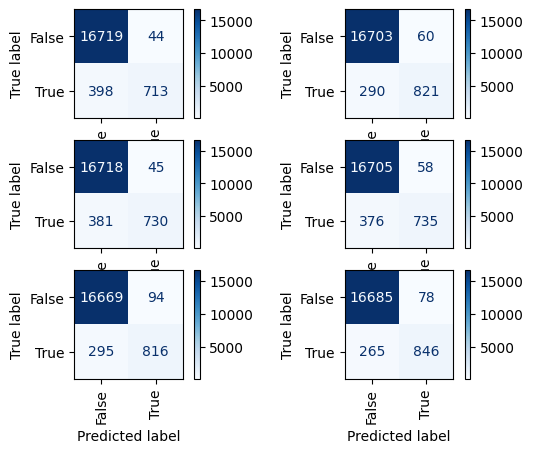

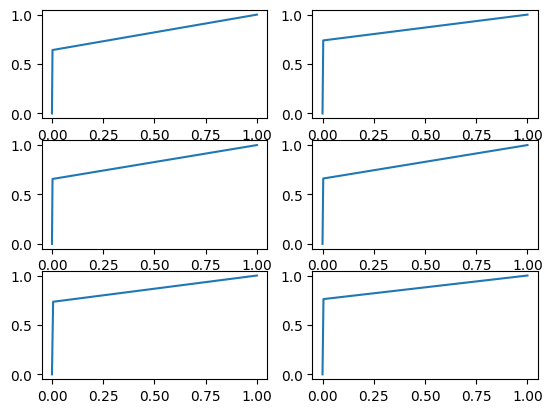

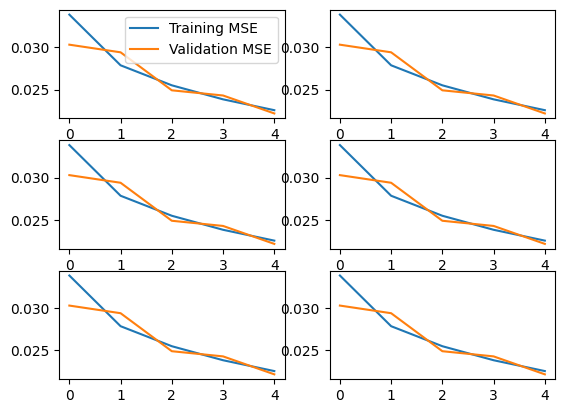

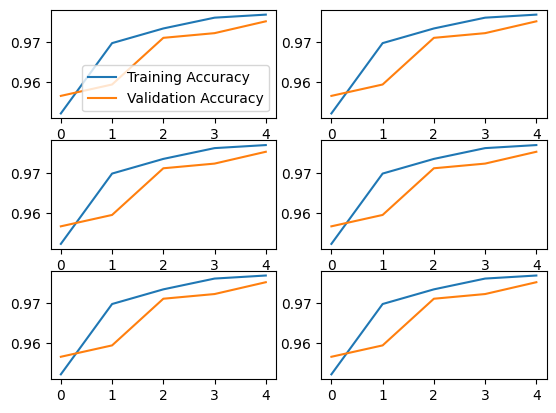

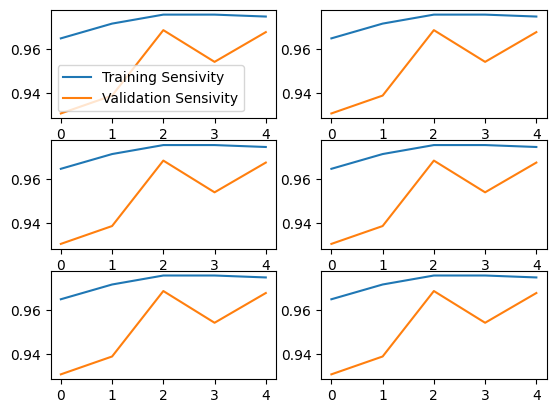

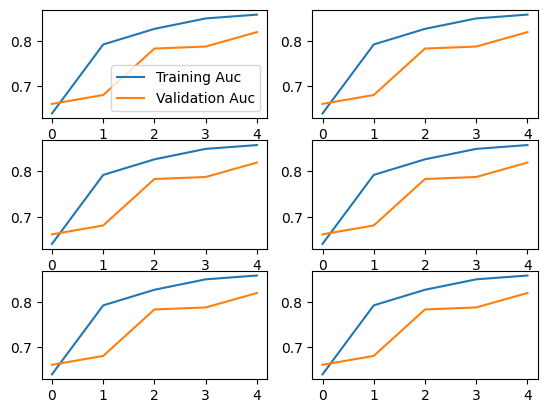

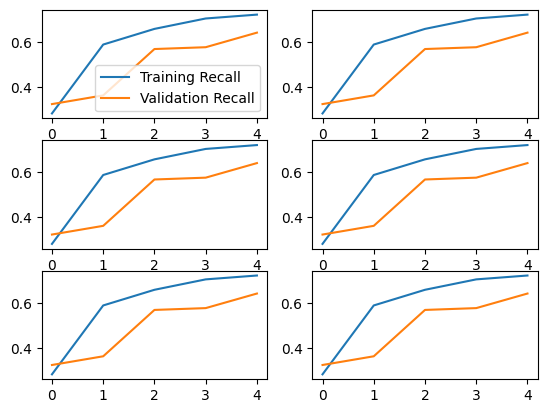

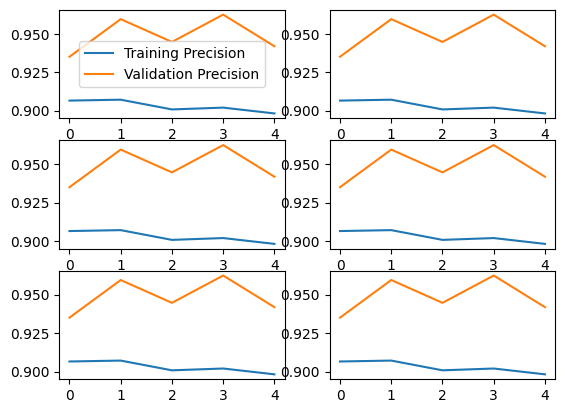

In [36]:
meanPredicted=createTeamOfModels('poisson',0)
displaySummarization(meanPredicted,0,18)

Funkcja categorical_crossentropy

Epoch 1/5


In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1665/1676 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9359 - sensitivity_at_specificity_37: 0.0182 - auc_37: 0.4999 - recall_37: 0.0000e+00 - precision_37: 0.0000e+00

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1676/1676 [==============================] - 9s 5ms/step - loss: 0.0000e+00 - mse: 0.0641 - accuracy: 0.9358 - sensitivity_at_specificity_37: 0.0181 - auc_37: 0.4999 - recall_37: 0.0000e+00 - precision_37: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_37: 0.0000e+00 - val_auc_37: 0.5000 - val_recall_37: 0.0000e+00 - val_precision_37: 0.0000e+00
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_37: 0.0000e+00 - auc_37: 0.5000 - recall_37: 0.0000e+00 - precision_37: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_37: 0.0000e+00 - val_auc_37: 0.5000 - val_recall_37: 0.0000e+00 - val_precision_37: 0.0000e+00
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_37: 0.0000e+00 - auc

INFO:tensorflow:Assets written to: categorical_crossentropy_cnn00\assets


INFO:tensorflow:Assets written to: categorical_crossentropy_cnn00\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5


In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1667/1676 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mse: 0.0642 - accuracy: 0.9358 - sensitivity_at_specificity_38: 0.0225 - auc_38: 0.5001 - recall_38: 2.9223e-04 - precision_38: 0.1667

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1676/1676 [==============================] - 9s 5ms/step - loss: 0.0000e+00 - mse: 0.0641 - accuracy: 0.9359 - sensitivity_at_specificity_38: 0.0224 - auc_38: 0.5001 - recall_38: 2.9121e-04 - precision_38: 0.1667 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_38: 0.0000e+00 - val_auc_38: 0.5000 - val_recall_38: 0.0000e+00 - val_precision_38: 0.0000e+00
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_38: 0.0000e+00 - auc_38: 0.5000 - recall_38: 0.0000e+00 - precision_38: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_38: 0.0000e+00 - val_auc_38: 0.5000 - val_recall_38: 0.0000e+00 - val_precision_38: 0.0000e+00
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_38: 0.0000e+00 - auc_38:

INFO:tensorflow:Assets written to: categorical_crossentropy_cnn01\assets


INFO:tensorflow:Assets written to: categorical_crossentropy_cnn01\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5


In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1670/1676 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mse: 0.0642 - accuracy: 0.9357 - sensitivity_at_specificity_39: 0.0277 - auc_39: 0.4999 - recall_39: 0.0000e+00 - precision_39: 0.0000e+00

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1676/1676 [==============================] - 9s 5ms/step - loss: 0.0000e+00 - mse: 0.0641 - accuracy: 0.9358 - sensitivity_at_specificity_39: 0.0277 - auc_39: 0.4999 - recall_39: 0.0000e+00 - precision_39: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_39: 0.0000e+00 - val_auc_39: 0.5000 - val_recall_39: 0.0000e+00 - val_precision_39: 0.0000e+00
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_39: 0.0000e+00 - auc_39: 0.5000 - recall_39: 0.0000e+00 - precision_39: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_39: 0.0000e+00 - val_auc_39: 0.5000 - val_recall_39: 0.0000e+00 - val_precision_39: 0.0000e+00
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_39: 0.0000e+00 - auc

INFO:tensorflow:Assets written to: categorical_crossentropy_cnn02\assets


INFO:tensorflow:Assets written to: categorical_crossentropy_cnn02\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5


In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1664/1676 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mse: 0.0641 - accuracy: 0.9357 - sensitivity_at_specificity_40: 0.0217 - auc_40: 0.5000 - recall_40: 2.9343e-04 - precision_40: 0.0500

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1676/1676 [==============================] - 9s 5ms/step - loss: 0.0000e+00 - mse: 0.0642 - accuracy: 0.9356 - sensitivity_at_specificity_40: 0.0215 - auc_40: 0.5000 - recall_40: 2.9121e-04 - precision_40: 0.0500 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_40: 0.0000e+00 - val_auc_40: 0.5000 - val_recall_40: 0.0000e+00 - val_precision_40: 0.0000e+00
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_40: 0.0000e+00 - auc_40: 0.5000 - recall_40: 0.0000e+00 - precision_40: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_40: 0.0000e+00 - val_auc_40: 0.5000 - val_recall_40: 0.0000e+00 - val_precision_40: 0.0000e+00
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_40: 0.0000e+00 - auc_40:

INFO:tensorflow:Assets written to: categorical_crossentropy_cnn03\assets


INFO:tensorflow:Assets written to: categorical_crossentropy_cnn03\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5


In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1670/1676 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mse: 0.0641 - accuracy: 0.9358 - sensitivity_at_specificity_41: 0.0237 - auc_41: 0.4999 - recall_41: 0.0000e+00 - precision_41: 0.0000e+00

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1676/1676 [==============================] - 9s 5ms/step - loss: 0.0000e+00 - mse: 0.0641 - accuracy: 0.9358 - sensitivity_at_specificity_41: 0.0236 - auc_41: 0.4999 - recall_41: 0.0000e+00 - precision_41: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_41: 0.0000e+00 - val_auc_41: 0.5000 - val_recall_41: 0.0000e+00 - val_precision_41: 0.0000e+00
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_41: 0.0000e+00 - auc_41: 0.5000 - recall_41: 0.0000e+00 - precision_41: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_41: 0.0000e+00 - val_auc_41: 0.5000 - val_recall_41: 0.0000e+00 - val_precision_41: 0.0000e+00
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_41: 0.0000e+00 - auc

INFO:tensorflow:Assets written to: categorical_crossentropy_cnn04\assets


INFO:tensorflow:Assets written to: categorical_crossentropy_cnn04\assets


559/559 [==============================] - 1s 2ms/step
Epoch 1/5


In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1669/1676 [============================>.] - ETA: 0s - loss: 0.0000e+00 - mse: 0.0642 - accuracy: 0.9358 - sensitivity_at_specificity_42: 0.0216 - auc_42: 0.5002 - recall_42: 5.8462e-04 - precision_42: 0.1429

In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.


1676/1676 [==============================] - 9s 5ms/step - loss: 0.0000e+00 - mse: 0.0641 - accuracy: 0.9358 - sensitivity_at_specificity_42: 0.0215 - auc_42: 0.5002 - recall_42: 5.8241e-04 - precision_42: 0.1429 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_42: 0.0000e+00 - val_auc_42: 0.5000 - val_recall_42: 0.0000e+00 - val_precision_42: 0.0000e+00
Epoch 2/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_42: 0.0000e+00 - auc_42: 0.5000 - recall_42: 0.0000e+00 - precision_42: 0.0000e+00 - val_loss: 0.0000e+00 - val_mse: 0.0622 - val_accuracy: 0.9378 - val_sensitivity_at_specificity_42: 0.0000e+00 - val_auc_42: 0.5000 - val_recall_42: 0.0000e+00 - val_precision_42: 0.0000e+00
Epoch 3/5
1676/1676 [==============================] - 8s 5ms/step - loss: 0.0000e+00 - mse: 0.0640 - accuracy: 0.9360 - sensitivity_at_specificity_42: 0.0000e+00 - auc_42:

INFO:tensorflow:Assets written to: categorical_crossentropy_cnn05\assets


INFO:tensorflow:Assets written to: categorical_crossentropy_cnn05\assets


559/559 [==============================] - 1s 2ms/step
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0
Marked example proportion: 0.10816535376853328 - Predicted proportion: 0.0


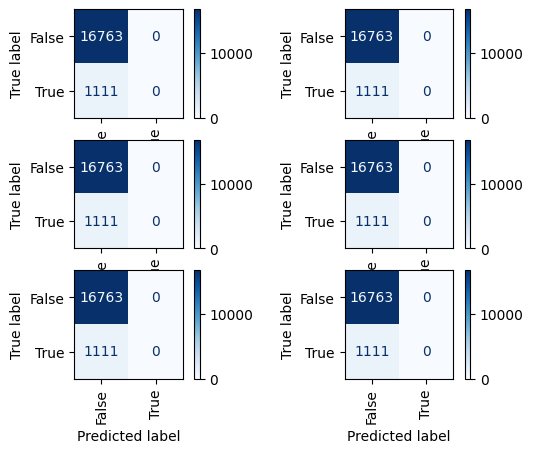

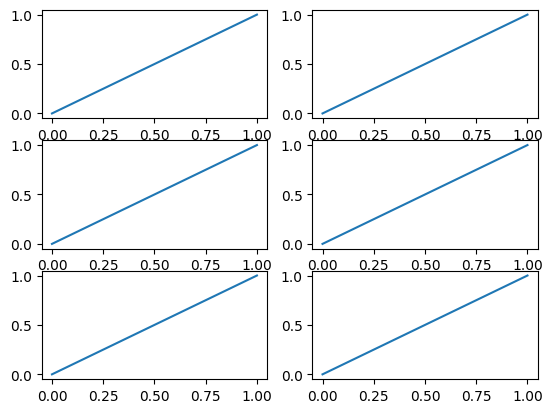

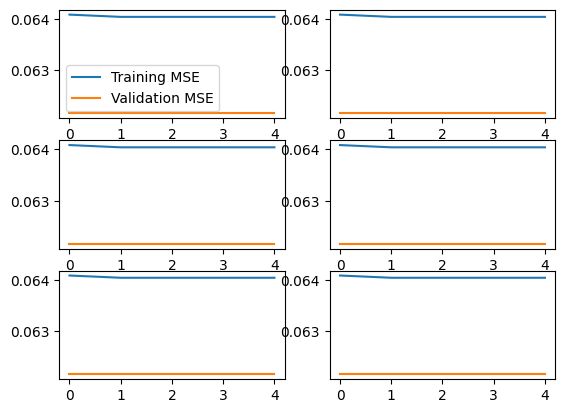

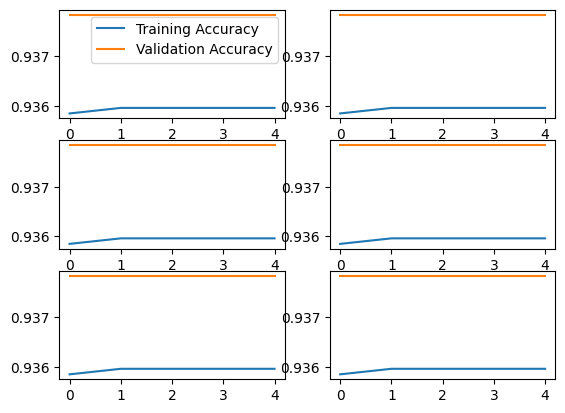

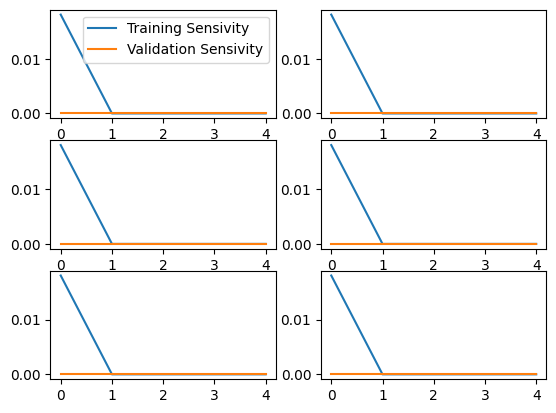

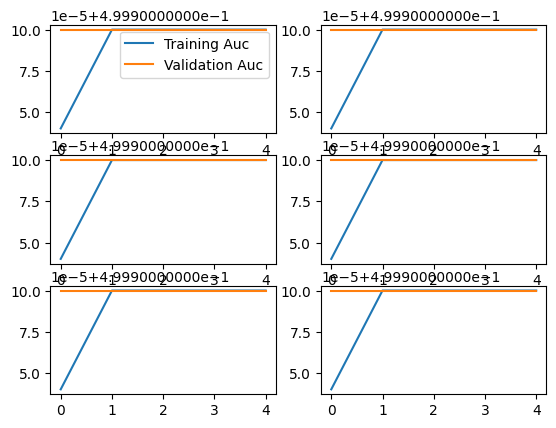

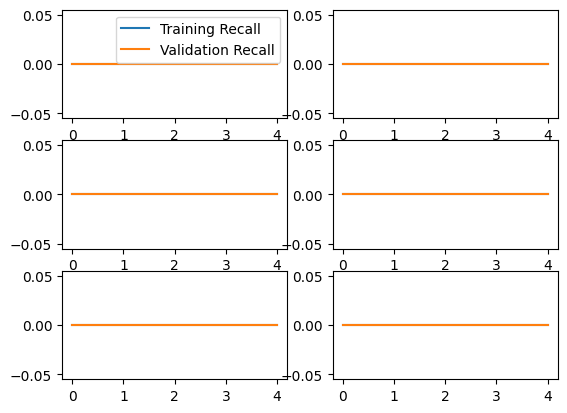

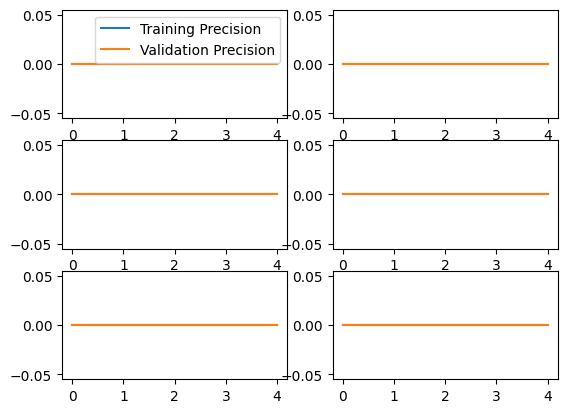

In [37]:
meanPredicted=createTeamOfModels('categorical_crossentropy',0)
displaySummarization(meanPredicted,0,24)